In [ ]:
from const import globs

In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM

D, V, M, k, gamma = globs('l')

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

From now on let's use the following simulated data for further testing

In [4]:
from simulator import Simulator

In [5]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


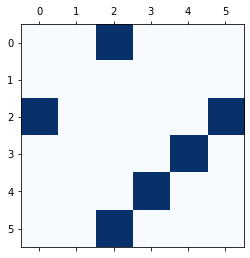

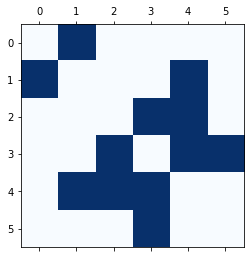

In [6]:
plt.matshow(test_data.G, cmap='Blues')
plt.matshow(random_initial_data.G, cmap='Blues')

# 2 MC SAMPLER

## 2.4.1 Sampling G and K (BDMCMC Sampling)

In [7]:
from samplers import serialize_matrix, deserialize_matrix

#### Serialization test

In [8]:
# This function is only used to test if the serialization and deserialization functions between R and python work properly
import subprocess


def serialization_function_test(n_tests=200, shape=(8,17)):    
    results = []
    for _ in range(n_tests):
        
        # Generate random matrix
        test_matrix = np.random.random(shape) * 100
        
        # Serialize matrix
        serialized_test_matrix = serialize_matrix(test_matrix)
        
        # Send to R script
        command = f"Rscript --vanilla serialize_matrix_test.R {serialized_test_matrix}"
        result = subprocess.run(command, 
                                shell=True, 
                                capture_output=True,
                                text=True)
        
        # Deserialize from R output
        deserialized_test_matrix = deserialize_matrix(result.stdout, shape=shape)
        differences = np.abs(test_matrix-deserialized_test_matrix)
        max_diff = np.max(differences)
        min_diff = np.min(differences)
        diff_sum = np.sum(differences)
        results.append({'max_diff': max_diff, 'min_diff': min_diff, 'diff_sum': diff_sum})
    return pd.DataFrame(results)

In [9]:
%%time
test_result_df = serialization_function_test()
test_result_df.head()

CPU times: user 431 ms, sys: 876 ms, total: 1.31 s
Wall time: 45.6 s


,max_diff,min_diff,diff_sum
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [10]:
test_result_df.describe(percentiles=[i * 0.1 for i in range(1, 10)])

,max_diff,min_diff,diff_sum
count,2.000000e+02,200.0,2.000000e+02
mean,1.132427e-16,0.0,1.132427e-16
std,8.678588e-16,0.0,8.678588e-16
min,0.000000e+00,0.0,0.000000e+00
10%,0.000000e+00,0.0,0.000000e+00
20%,0.000000e+00,0.0,0.000000e+00
30%,0.000000e+00,0.0,0.000000e+00
40%,0.000000e+00,0.0,0.000000e+00
50%,0.000000e+00,0.0,0.000000e+00
60%,0.000000e+00,0.0,0.000000e+00


### Task:

You must implement a function that receives matrices $W$, $Z_{i+1}$ and $H_{i+1}$ and generates the next $G_{i+1}$ and $K_{i+1}$.

In [11]:
from samplers import MC_sample_GK

## 2.4.2 G and K Sampling Tests

#### MC_sample_GK tests

In [12]:
# Check that the function runs with no issues, without side effects
G_copy = random_initial_data.G.copy()
H_copy = test_data.H.copy()
degrees_of_freedom_b = k - 1
shape_matrix = np.eye(k)

wt_sample, G_sample, K_sample = MC_sample_GK(G_copy, H_copy, degrees_of_freedom_b, debug=True)

[1] "[R] Matrix G:"
     V1 V2 V3 V4 V5 V6
[1,]  0  1  0  0  0  0
[2,]  1  0  0  0  1  0
[3,]  0  0  0  1  1  0
[4,]  0  0  1  0  1  1
[5,]  0  1  1  1  0  0
[6,]  0  0  0  1  0  0
[1] "[R] Data Matrix:"
             V1         V2         V3         V4         V5         V6
[1,] 113.902604 -18.740222  -2.574988 -15.345477 -19.373414  -3.674199
[2,] -18.740222  79.907268   2.299193   2.379722  -6.338472 -19.018370
[3,]  -2.574988   2.299193 101.449047   6.748986  -9.993750  79.772529
[4,] -15.345477   2.379722   6.748986  98.183702  75.337787  10.601217
[5,] -19.373414  -6.338472  -9.993750  75.337787 165.112490 -10.433948
[6,]  -3.674199 -19.018370  79.772529  10.601217 -10.433948 149.098644
[1] "[R] Shape Matrix:"
     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    1    0    0    0    0    0
[2,]    0    1    0    0    0    0
[3,]    0    0    1    0    0    0
[4,]    0    0    0    1    0    0
[5,]    0    0    0    0    1    0
[6,]    0    0    0    0    0    1
[1] "[R] Iterations:"
[1] 2
2 

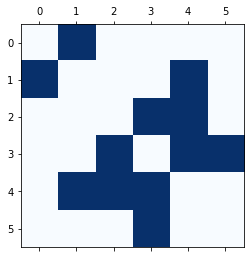

In [13]:
plt.matshow(G_sample, cmap='Blues')

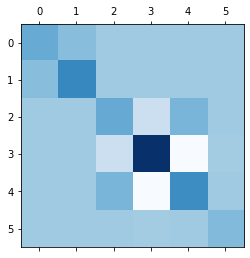

In [14]:
plt.matshow(K_sample, cmap='Blues')  # Why is this NOT a mask of G?

In [15]:
%%time
# Check that the Sampler works properly (This will take... forever)
K_errors = []
G_errors = []
wrong_edges = []
matrix_changes = []
burn_in = 1000
for i in range(5000):
    K_sample_old = K_sample.copy()
    G_sample_old = G_sample.copy()
    wt_sample, G_sample, K_sample = MC_sample_GK(G_sample, H_copy, degrees_of_freedom_b, debug=False)
    matrix_changes.append(~np.all(K_sample_old == K_sample))
    if i >= burn_in:
        K_errors.append(np.linalg.norm(K_sample - test_data.K))  # Computing error wrt the target matrix        
        G_errors.append(np.linalg.norm(G_sample - test_data.G))  # Computing error wrt the target matrix
        wrong_edges.append(np.sum(np.abs(G_sample - test_data.G)))  # Computing error wrt the target matrix

CPU times: user 7.84 s, sys: 23.2 s, total: 31 s
Wall time: 1h 31min 33s


K matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

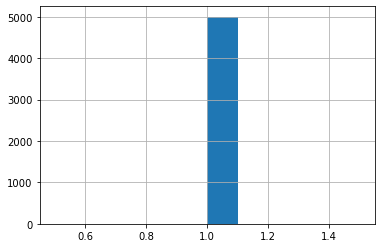

In [16]:
# K matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("K matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

K L2-error metrics
count    4000.000000
mean        3.512013
std         0.008490
min         3.479395
25%         3.506447
50%         3.512659
75%         3.518137
max         3.538883
dtype: float64


<AxesSubplot:>

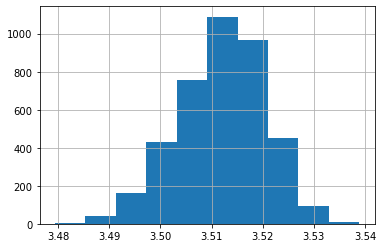

In [17]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
K_errors = pd.Series(K_errors)
print("K L2-error metrics")
print(K_errors.describe())
K_errors.hist()

K L2-error series


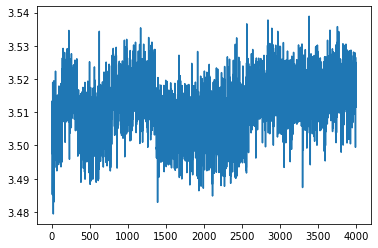

In [18]:
K_errors.plot()
print("K L2-error series")

In [ ]:
graphs = []
counts = []
cut=4000
max_iterations=5000
not_found = True
for it in range(cut,max_iterations):
    not_found = True
    for j in range(len(graphs)):
        if np.all(sampled_Gs1[it] == graphs[j]):
            counts[j] += wt_sample[it]
            not_found = False
    if not_found:
        graphs.append(sampled_Gs1[it])
        counts.append(wt_sample[it])

plt.bar(range(len(counts)),counts)
plt.suptitle('Sampled graphs histogram', x=0.5, y=1, ha='center')
plt.show()

modes = pd.Series(counts).sort_values()

plt.matshow(graphs[counts.index(modes[0])], cmap='Blues')
plt.suptitle("Most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

plt.matshow(graphs[counts.index(modes[1])], cmap='Blues')
plt.suptitle("Second most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

plt.matshow(graphs[counts.index(modes[2])], cmap='Blues')
plt.suptitle("Third most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

In [ ]:
we = [] #wrong edges unique
counts = []
cut=4000
max_iterations=5000
not_found = True
for it in range(cut,max_iterations):
    not_found = True
    for j in range(len(we)):
        if np.all(wrong_edges[it] == we[j]):
            counts[j] += wt_sample[it]
            not_found = False
    if not_found:
        we.append(wrong_edges[it])
        counts.append(wt_sample[it])

plt.hist(we, weights=counts)
plt.suptitle('Wrong Edges histogram', x=0.5, y=1, ha='center')
plt.show()

modes = pd.Series(counts).sort_values()


G L2-error metrics
count    4000.000000
mean        2.091812
std         0.609439
min         1.414214
25%         1.414214
50%         2.449490
75%         2.449490
max         3.162278
dtype: float64


<AxesSubplot:>

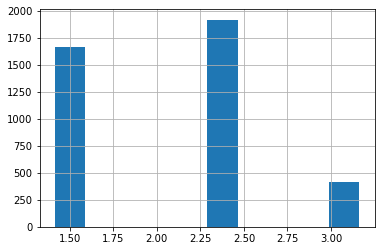

In [19]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
G_errors = pd.Series(G_errors)
print("G L2-error metrics")
print(G_errors.describe())
G_errors.hist()

G L2-error series


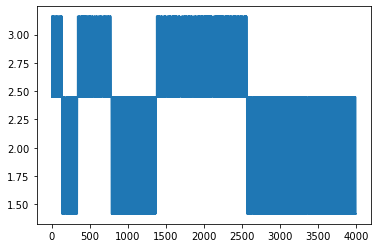

In [20]:
G_errors.plot()
print("G L2-error series")

G wrong edges count
count    4000.000000
mean        4.747000
std         2.599169
min         2.000000
25%         2.000000
50%         6.000000
75%         6.000000
max        10.000000
dtype: float64


<AxesSubplot:>

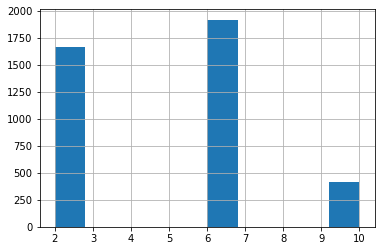

In [21]:
wrong_edges = pd.Series(wrong_edges)
print("G wrong edges count")
print(wrong_edges.describe())
wrong_edges.hist()

G wrong edges series


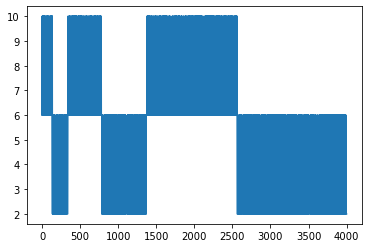

In [22]:
wrong_edges.plot()
print("G wrong edges series")